<a href="https://colab.research.google.com/github/EthanBerlant/Jedha_Final_Project/blob/main/Automated_NLPing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
from functools import reduce
from datetime import datetime
from dateutil.parser import parse
import fnmatch

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import regularizers, Model
from keras.models import Sequential
from keras.layers import Input, Dense, concatenate, AveragePooling1D
from keras.losses import MeanAbsolutePercentageError
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

!git clone 'https://github.com/EthanBerlant/Jedha_Final_Project.git'

Cloning into 'Jedha_Final_Project'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 160 (delta 12), reused 11 (delta 7), pack-reused 132
Receiving objects: 100% (160/160), 35.79 MiB | 17.94 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# "Token based text 128-embedding trained on English Google News 200B corpus."
embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1")

In [3]:
# Function removing '@' and '#' characters, and links, from tweets.
def cleaning(tweet):
  new_tweet = []
  for word in tweet.split():
    if word not in fnmatch.filter(tweet.split(), 'http*'):
      new_tweet.append(word.replace('@','').replace('#',''))
  return ' '.join(new_tweet)

In [4]:
def ModelBuilder(layer_dimensions=[128,64,32], activation='relu'):
  model = Sequential()
  for dim in layer_dimensions:
    model.add(Dense(units=dim,
                    activation=activation,
                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-6)
                    ))
  model.add(Dense(units=3,
                  activation='linear',
                  bias_initializer=tf.keras.initializers.Constant(value=2000),
                  kernel_regularizer=regularizers.L2(1e-2)
                  ))
  model.compile(loss='MeanAbsoluteError', 
                optimizer='adam', 
                metrics=['MeanAbsoluteError', 'MeanAbsolutePercentageError']
                )
  return model

In [5]:
# Function that creates an embedding for each tweet, then takes all the tweets from a given source
# in a given day, and averages their embeddings, so that there is one embedding per day per source

def targetize(key, target):
  tweet_embedding_df = pd.DataFrame(embed(tweet_dict[key][key]).numpy())
  tweet_embedding_df['date'] = tweet_dict[key]['date']
  return pd.merge(tweet_embedding_df.groupby(by='date').mean(), target, on='date')

In [6]:
# Setting up a dataframe with SPX closing prices 1 day ahead, 7 days ahead, and 15 days ahead.
# The 7- and 15-day-ahead columns are based on the rolling 7- and 15-day averages, respectively.

target = pd.read_feather('Jedha_Final_Project/Data/cleaned_dataset.ftr')
SPX = [col for col in target.columns if 'SPX' in col]
SPX.insert(0,'date')
target = target[SPX].copy()
target['date'] = target['date'].apply(datetime.date)

target['SPX_close-1'] = target['SPX_close'].shift(-1)
target['SPX_close-7'] = target['SPX_close-7'].shift(-7)
target['SPX_close-15'] = target['SPX_close-15'].shift(-15)
target = target.dropna().reset_index(drop=True)

In [7]:
# Creating dictionary of tweet dataframes, cleaning the tweets, and converting them to embeddings.

file_list = [file.replace('.json','') for file in os.listdir('Jedha_Final_Project/Tweets') if '.json' in file]
tweet_dict = {filename : pd.read_json(f'Jedha_Final_Project/Tweets/{filename}.json').drop(['Tweet Id', 'Username'], axis=1) for filename in file_list}

for key, df in zip(tweet_dict.keys(), tweet_dict.values()):
  tweet_dict[key] = tweet_dict[key].rename(columns={'Datetime':'date','Text':key})
  tweet_dict[key]['date'] = tweet_dict[key]['date'].apply(datetime.date)
  tweet_dict[key][key] = tweet_dict[key][key].apply(cleaning)
  tweet_dict[key] = targetize(key, target)

In [8]:
X_columns = [col for col in tweet_dict['wsj'].columns if (col != 'date') and ('SPX_close-' not in str(col))]
y_columns = [col for col in tweet_dict['wsj'] if 'SPX_close-' in str(col)]
train_test_date_split = datetime(year=2022, month=5, day=1)

X_train_dict = {key : tweet_dict[key][pd.to_datetime(tweet_dict[key]['date']) <= train_test_date_split][X_columns] for key in tweet_dict.keys()}
y_train_dict = {key : tweet_dict[key][pd.to_datetime(tweet_dict[key]['date']) <= train_test_date_split][y_columns] for key in tweet_dict.keys()}
X_test_dict = {key : tweet_dict[key][pd.to_datetime(tweet_dict[key]['date']) > train_test_date_split][X_columns] for key in tweet_dict.keys()}
y_test_dict = {key : tweet_dict[key][pd.to_datetime(tweet_dict[key]['date']) > train_test_date_split][y_columns] for key in tweet_dict.keys()}

In [ ]:
# # Testing the predictive power of the tweet sources individually; they seem to be giving some information about the SPX price.

# model_dict = {key : ModelBuilder() for key in tweet_dict.keys()}

# callbacks = [tf.keras.callbacks.EarlyStopping(patience=20, 
#                                               restore_best_weights=True)]

# for key in tweet_dict.keys():
#   model_dict[key].fit(x=X_train_dict[key],
#                       y=y_train_dict[key],
#                       validation_data=(X_test_dict[key],
#                                        y_test_dict[key]),
#                       epochs=600,
#                       callbacks=callbacks)

In [ ]:
# bob = ModelBuilder()

# y_pred = bob.predict(X_test)

# predictions = pd.DataFrame(y_pred, columns=['SPX_close-1','SPX_close-7','SPX_close-15'], index=joining_dict['wsj'][pd.to_datetime(joining_dict['wsj']['date']) > train_test_date_split].index)
# predictions['date'] = joining_dict['wsj'][pd.to_datetime(joining_dict['wsj']['date']) > train_test_date_split]['date']
# y_real = pd.DataFrame(y_test, columns=['SPX_close-1','SPX_close-7','SPX_close-15'])
# y_real['date'] = joining_dict['wsj'][pd.to_datetime(joining_dict['wsj']['date']) > train_test_date_split]['date']

In [ ]:
# y_pred = X_test['SPX_close']

# predictions = pd.DataFrame(y_pred, columns=['SPX_close-1'], index=joining_dict['wsj'][pd.to_datetime(joining_dict['wsj']['date']) > train_test_date_split].index)
# predictions['date'] = joining_dict['wsj'][pd.to_datetime(joining_dict['wsj']['date']) > train_test_date_split]['date']
# y_real = pd.DataFrame(y_test, columns=['SPX_close-1'])
# y_real['date'] = joining_dict['wsj'][pd.to_datetime(joining_dict['wsj']['date']) > train_test_date_split]['date']

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=predictions['date'], 
#                          y=predictions['SPX_close-1'],
#                          mode='lines',
#                          name='Predicted Values'))
# fig.add_trace(go.Scatter(x=y_real['date'], 
#                          y=y_real['SPX_close-1'],
#                          mode='lines',
#                          name='Real Values'))

# fig.show()

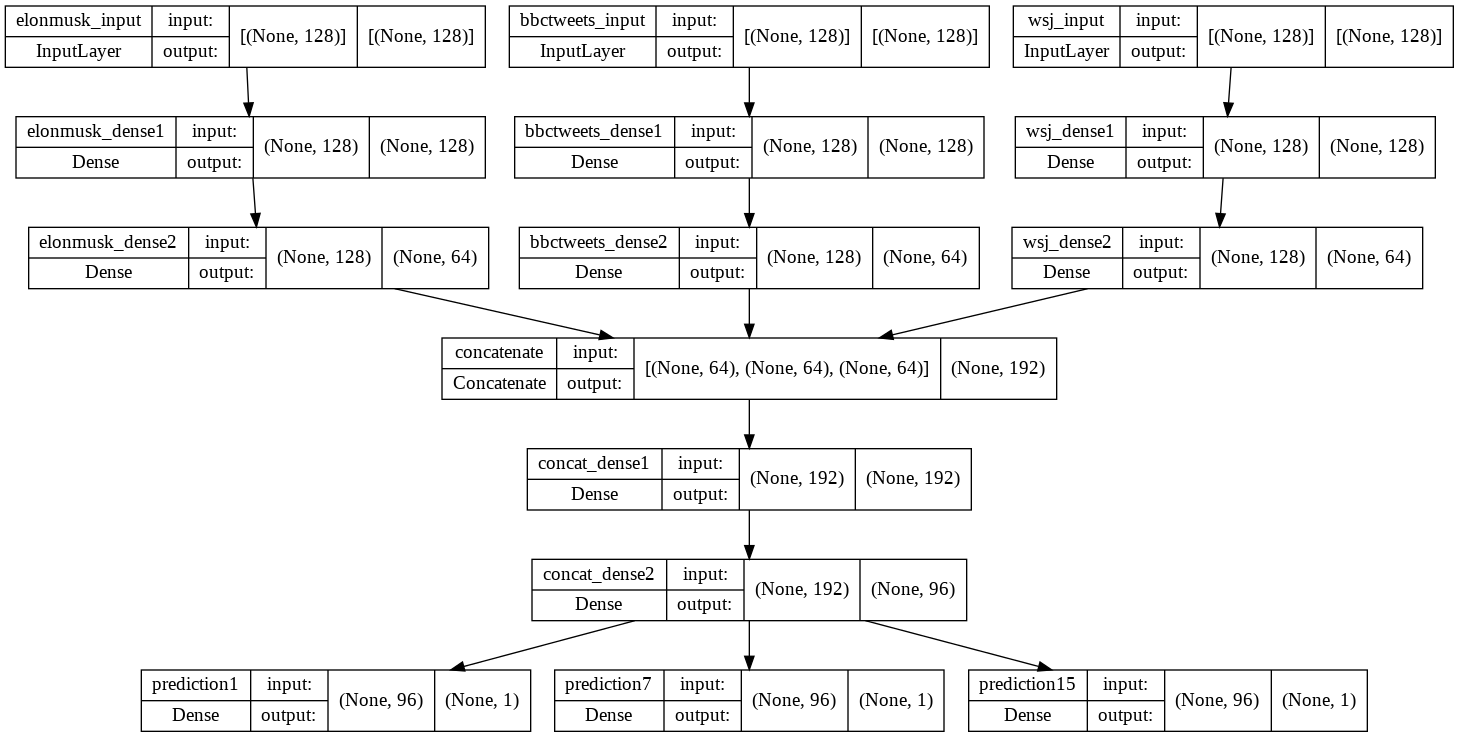

In [ ]:
input_dict    = {f'{key}_input'  : Input(shape=(128,), name=f'{key}_input') for key in tweet_dict.keys()}
dense1_dict   = {f'{key}_dense1' : Dense(128, activation='relu', name=f'{key}_dense1')(input_dict[f'{key}_input']) for key in tweet_dict.keys()}
dense2_dict   = {f'{key}_dense2' : Dense(64, activation='relu', name=f'{key}_dense2')(dense1_dict[f'{key}_dense1']) for key in tweet_dict.keys()}
tweet_concat  = concatenate([dense2_dict[f'{key}_dense2'] for key in tweet_dict.keys()])
concat_dense1 = Dense(64*len(tweet_dict.keys()), activation='relu', name='concat_dense1')(tweet_concat)
concat_dense2 = Dense(32*len(tweet_dict.keys()), activation='relu', name='concat_dense2')(concat_dense1)
prediction1   = Dense(1, activation='linear', name='prediction1')(concat_dense2)
prediction7   = Dense(1, activation='linear', name='prediction7')(concat_dense2)
prediction15  = Dense(1, activation='linear', name='prediction15')(concat_dense2)

model = Model(
    inputs=[input_dict[f'{key}_input'] for key in tweet_dict.keys()],
    outputs=[prediction1, prediction7, prediction15],
)

model.compile(
    #optimizer=keras.optimizers.RMSprop(1e-3),
    optimizer='adam',
    loss=[
        'MeanAbsoluteError',
        #'MeanSquaredError',
        ],
    metrics=['MeanAbsoluteError', 
             'MeanAbsolutePercentageError'
             ]
)

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=20, 
                                              restore_best_weights=True)]

model.fit(X_train_dict,
          y_train_dict,
          epochs=600,
          callbacks=callbacks
          )

ValueError: ignored